# Problem Description

Given an image of a fashion item, build a deep learning model that recognizes the fashion item. You must use at least 2 different architectures, one with MLPs and one with CNNs. Use the Fashion-MNIST dataset to train and evaluate your models. More information about the task and the dataset can be found at https://github.com/zalandoresearch/fashion-mnist. The dataset is also available from Tensorflow.

## 

# Imports

In [2]:
import gc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from typing import List, Dict, Optional, Tuple, Any, Union

import wandb
from wandb.keras import WandbCallback

In [3]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Num GPUs Available:  2
Number of accelerators:  2


# Weights & Biases

In order to make experiment tracking easier we will use [Weights & Biases](wandb.ai/home), which offers a free lisence for academic purposes. For the sake of this assignment a team has been created:https://wandb.ai/aueb. Access can be granted by contacting the authors.

* Note that this code assumes that you have already set up a Wandb account and API key. If you haven't done so yet, you will need to sign up for a free account at https://wandb.ai/ and follow the instructions there to obtain your API key.



In [4]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load the data

The dataset can be downloaded directly through [keras.datasets](https://keras.io/api/datasets/fashion_mnist/) which returns a Tuple of NumPy arrays: `(X_train, y_train), (X_test, y_test)`. The Label-description mapping is presented below:

| Label | Description   |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

This part of the project will use MLPs, thus the data is flattened into 784 vectors. Moreover, the data will be converter to 

In [5]:
classes: int = 10
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
input_shape = (28, 28, 1)
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

4422102/4422102 [==============================] - 0s 0us/step


## Globals



In [6]:
class_names: List[str] = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label_mapping: dict = dict(zip(list(range(10)), class_names))

# Visualize 

Before proceeding we will visualize a sample of the images. One image from each category is shown.

In [6]:
def plot_mnist(X_train: np.ndarray, 
               y_train: np.ndarray,
               class_names: List[str],
               n_rows: int=2,
               n_cols: int=5,
               figsize: Tuple[int]=(10, 6),
               y: float=0.9
              ) -> None:  
    """Print a sample of unique images given a train set (X and y) along with the label names"""
    
    # Select 10 random samples with unique labels
    idx = []
    while len(idx) < len(class_names):
        i = np.random.randint(len(X_train))
        if y_train[i] not in idx:
            idx.append(y_train[i])
    
    # Create to n_rowsxn_cols plot
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):

        # plot image
        ax.imshow(X_train[y_train == idx[i]][0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        # add label
        ax.set_xlabel(class_names[idx[i]], fontsize=12)

    plt.suptitle(f"{len(class_names)} Random (Unique) Samples from Training Set", 
                 fontsize=16,
                 y=y)
    plt.tight_layout()
    _ = plt.show()

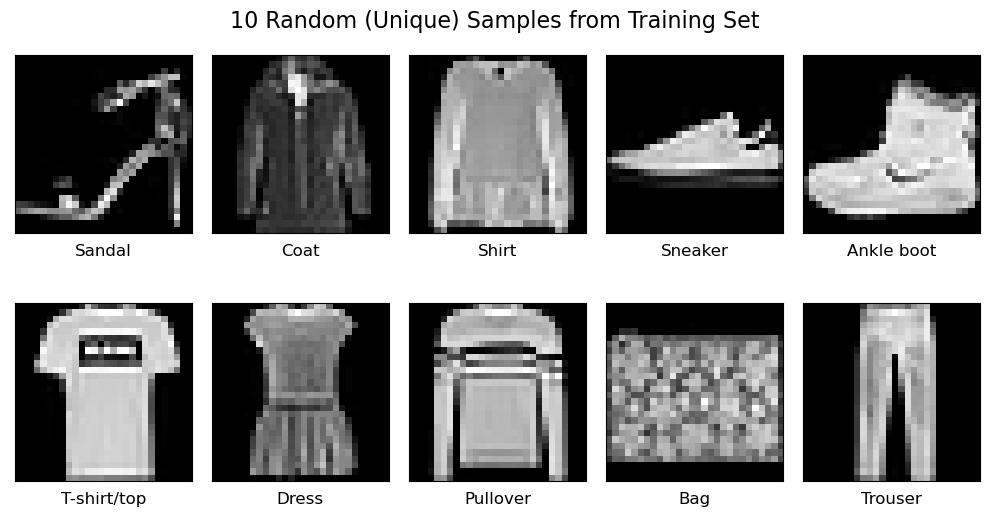

In [7]:
plot_mnist(X_train=X_train, y_train=y_train, class_names=class_names)

We wil also see if the lables are balanced:

In [8]:
def plot_label_freq(y_train: np.ndarray,
                    y_test:  np.ndarray,
                    normalize: bool=True,
                    figsize: Tuple[int]=(10, 6),) -> None:
    
    # Get unique labels and their frequency in train and test sets
    labels, train_freq = np.unique(y_train, return_counts=True)
    _, test_freq = np.unique(y_test, return_counts=True)

    if normalize:
        train_freq = train_freq/len(y_train)
        test_freq = test_freq/len(y_test)
    # Plot side-by-side bar chart
    fig, ax = plt.subplots(figsize=figsize)
    bar_width = 0.35
    opacity = 0.8
    index = np.arange(len(labels))
    train_bars = ax.bar(index, train_freq, bar_width,
                    alpha=opacity,
                    color='#4E79A7',
                    label='Train')
    test_bars = ax.bar(index + bar_width, test_freq, bar_width,
                    alpha=opacity,
                    color='#F28E2B',
                    label='Test')

    # Add labels and ticks
    ax.set_xlabel('Labels')
    ax.set_ylabel('Frequency')
    ax.set_title('Label Frequency (normalized) in Train and Test Sets', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Label")
    plt.tight_layout()
    _ = plt.show()


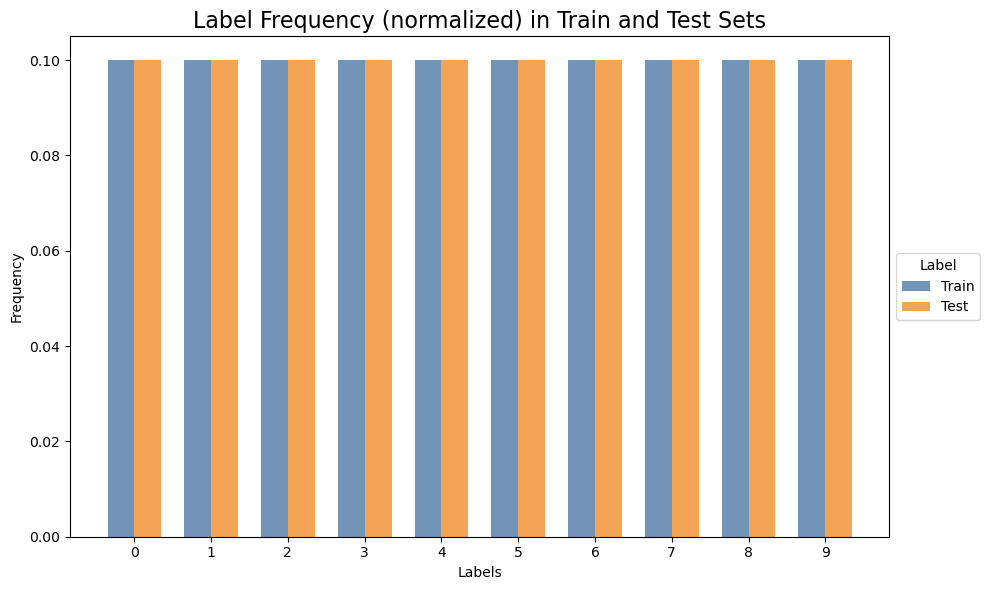

In [9]:
plot_label_freq(y_train=y_train, y_test=y_test)

# Convolutional Neural Network (CNN)

In this part of the assignmed we will evaluate the performance of a ANN architecture. 

* We will first build a base model with 3 conv_layers, which will be used as a baseline. 
* Based on the results we get we will create a sweep configuration to optimize hypterparameters

Experiments will be tracked in wandb, thus no plots will be presented in this report. 

## Cleanup

In [10]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

## Build Model

The `train_model` function will be used as the code function which will build the models needed for each step. 

In [ ]:
def train_model(
        train_data: np.ndarray,
        train_labels: np.ndarray,
        optimizer: tf.keras.optimizers,
        epochs: int = 5,
        batch_size: int = 128,
        conv_layers: int = 2,
        conv_activation: str = 'relu',
        output_activation: str = 'softmax',
        verbose: int = 0, 
        callbacks: Optional[List[Any]] = None, 
        dropout: Optional[float] = None) -> tuple:
    
    np.random.seed(42) # Define the seed for numpy to have reproducible experiments.
    set_seed(42) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    _input = Input(
        shape=input_shape,
        name='Input'
    )

    x = _input
     # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=_input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

### Model variables & Functions

the function `opt_es` will be used to return the optimizer and the early_stopping object for the sake of simplicity.

References: https://medium.com/@himanshuit3036/is-your-epochs-not-performing-try-callbacks-76519f0368a9

In [11]:
epochs: int = 100

def opt_es(learning_rate=0.001, monitor='val_accuracy', patience=10) -> tuple:
    """return the Adam optimizer and the readly stopping"""
    optimizer = Adam(learning_rate=learning_rate)
    early_stopping = EarlyStopping(
            monitor=monitor,
            patience=patience,
            verbose=1,
            restore_best_weights=True
        )
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    return optimizer, early_stopping, reduceLR

In [12]:
def print_eval(hs, _eval) -> None:
    """Prints Train, validation and test metrics for an input hs object"""
    
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(_eval[0]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(_eval[1]))

### Baseline model 3 conv layers

link: https://wandb.ai/aueb/Deep_Learning_1

In [ ]:
wandb.init(project="Deep_Learning_1", 
           name="MLP_CNN_baseline")


optimizer, early_stopping, reduceLR = opt_es()
# 3 Convolutional Layers 
model, hs = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=128,
    conv_layers=3,
    conv_activation='relu',
    output_activation='softmax',
    callbacks=WandbCallback(),
    dropout=True
)

# Evaluate on test data and show all the results.
_eval = model.evaluate(X_test, Y_test, verbose=1)
print_eval(hs, _eval)
clean_up(model=model)
wandb.finish()

### First comment on the results

The models works surprisingly well, compared to the MLP one. We managed to match the accuracy of the fully optimized MLP model, with arelatively simple architecture. Nevertheless, we will try to fully optimize the model. 

We can see that the model reaches a plateau, whithout overfitting. This indicates that we should slightly increase the complexity of the model.
Moreover, curves are not very smooth, thus we could try decreasing the learning rate.

We will biuld a new, cmore complex function, in order to create a new sweep.


### Hyperparameter tuning 

* We will start by building a function names `train_model` which can build a model with the following blocks:

    * Conv2D
    * Batch Normalization
    * Dropout
    * 2D Max Polling
    
Each layer will be build based on a list input, and depending on the value the Batch Normalization,  Dropout and max polling layers can be skipped.

In [8]:
def train_model(
        train_data: np.ndarray,
        train_labels: np.ndarray,
        optimizer: tf.keras.optimizers,
        batch_size: int,
        filter_size: List[int],
        kernel_size: List[int],
        batch_norm: List[bool],
        max_pooling_size: List[int],
        dropout: List[Optional[float]],
        conv_activation: str = 'relu',
        output_activation: str = 'softmax',
        callbacks: Optional[List[Any]] = None, 
        verbose: int = 0,
        epochs: int = 100) -> tuple:
    """Function used to build and train a model. Based on the input Data."""
    
    
    assert len(filter_size) == len(kernel_size) == len(batch_norm) == len(max_pooling_size) == len(dropout)
    
    np.random.seed(42) # Define the seed for numpy to have reproducible experiments.
    set_seed(42) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    _input = Input(
        shape=input_shape,
        name='Input'
    )

    x = _input
     # Define the convolutional layers.
    for i, filters in enumerate(filter_size):
        x = Conv2D(
            filters=filters,
            kernel_size=(kernel_size[i], kernel_size[i]),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        
        if batch_norm[i]:
            x = BatchNormalization(
                name='BatchNormalization-{0:d}'.format(i + 1)
            )(x)

        if dropout[i]:
            x = Dropout(
                rate=dropout[i],
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
            
        if max_pooling_size[i]:
            x = MaxPool2D(
                pool_size=(max_pooling_size[i], max_pooling_size[i]),
                strides=(2, 2),
                padding='same',
                name='MaxPool2D-{0:d}'.format(i + 1)
            )(x)
            
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=_input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
#         validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

#### Generate random combinations of inputs

For each parameter we create a pool of inputs and generate random lists (of length 4) which will be used as an input in the wandb sweep configuration.

In [12]:
def generate_lists(pool: List[Any], list_len: int = 10) -> List[List[Any]]:
    """
    Generates a specified number of lists of random items from a given pool.
    
    Parameters:
        - pool: a list of items from which to randomly select elements for the generated lists.
        - list_len (optional): an integer that specifies the number of lists to generate. The default value is 10.
    
    Returns:
        A list of lists, where each inner list contains a random selection of items from the input pool.
    """
    
    lists: List[List[Any]] = []
    while len(lists) < list_len:
        selection = [np.random.choice(pool) for _ in range(number_of_layers)]
        if selection not in lists:
            lists.append(selection)
            
    return lists

In [13]:
from pprint import pprint


number_of_layers: int = 4
epochs = 100

# create pool of values
filter_size_pool: List[int] = [2**i for i in range(4, 11)]
kernel_size_pool: List[int] = list(range(3, 8, 2))
batch_norm_pool: List[bool] = [True, False]
max_pooling_size_pool: List[int] = [0, 2, 4]
dropout_pool: List[float] = [i/10 for i in [0, 2, 4, 6]]
    
# create random lists
filter_size_val = generate_lists(filter_size_pool, 10) 
kernel_size_val = generate_lists(kernel_size_pool, 10) 
batch_norm_val = generate_lists(batch_norm_pool, 10) 
max_pooling_size_val = generate_lists(max_pooling_size_pool, 10) 
dropout_val = generate_lists(dropout_pool, 10) 

# pprint(dropout_val)

### Create sweep configuration and run model

Link: https://wandb.ai/aueb/MLP_CNN_Sweep_1/sweeps/wx18ltqs

In [ ]:

sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_loss'
        },
    'parameters': {
        'batch_size': {'values': [64, 
                                  128, 
                                  512]},
        'filter_size': {'values': [[64, 256, 32, 16],
                                 [16, 128, 1024, 16],
                                 [128, 32, 128, 512],
                                 [256, 512, 512, 512],
                                 [256, 32, 64, 1024],
                                 [1024, 512, 512, 128],
                                 [256, 64, 128, 512],
                                 [512, 512, 128, 64],
                                 [64, 16, 512, 512],
                                 [256, 32, 32, 128]]},
        'kernel_size': {'values': [[5, 3, 7, 5],
                                 [3, 3, 3, 5],
                                 [7, 7, 3, 5],
                                 [3, 7, 5, 5],
                                 [5, 5, 7, 5],
                                 [5, 3, 7, 3],
                                 [7, 5, 3, 7],
                                 [7, 5, 5, 3],
                                 [5, 5, 3, 5],
                                 [3, 3, 7, 3]]},
        'batch_norm': {'values': [[True, True, False, False],
                                 [False, True, False, True],
                                 [False, True, True, True],
                                 [False, True, False, False],
                                 [False, False, True, True],
                                 [True, False, False, False],
                                 [False, False, False, False],
                                 [True, False, True, False],
                                 [True, True, True, False],
                                 [False, False, True, False]]},
        'max_pooling_size': {'values': [[0, 0, 4, 2],
                                     [0, 4, 2, 4],
                                     [0, 0, 0, 4],
                                     [4, 0, 4, 0],
                                     [0, 2, 4, 0],
                                     [0, 4, 2, 2],
                                     [4, 0, 2, 0],
                                     [2, 2, 2, 2],
                                     [2, 4, 0, 4],
                                     [2, 0, 2, 0]]},
        'dropout': {'values': [[0.4, 0.0, 0.6, 0.2],
                             [0.4, 0.0, 0.0, 0.4],
                             [0.2, 0.2, 0.2, 0.6],
                             [0.0, 0.0, 0.0, 0.6],
                             [0.0, 0.6, 0.2, 0.4],
                             [0.0, 0.0, 0.2, 0.4],
                             [0.6, 0.4, 0.2, 0.2],
                             [0.4, 0.6, 0.6, 0.0],
                             [0.6, 0.4, 0.2, 0.0],
                             [0.0, 0.2, 0.6, 0.2]]},
        'learning_rate': {'values': [0.0001, 0.0005]}
    }
}

In [ ]:
# Initialize sweep by passing in config. (Optional) Provide a name of the project.
sweep_id = wandb.sweep(sweep=sweep_configuration, project='MLP_CNN_Sweep_1')


def main():
    
    run = wandb.init()

    optimizer, early_stopping, reduceLR = opt_es(learning_rate=wandb.config.learning_rate)

    # train model
    model, hs = train_model(
        train_data=X_train,
        train_labels=Y_train,
        optimizer=optimizer,
        epochs=epochs,
        batch_size=wandb.config.batch_size,
        filter_size=wandb.config.filter_size,
        kernel_size=wandb.config.kernel_size,
        batch_norm=wandb.config.batch_norm,
        max_pooling_size=wandb.config.max_pooling_size,
        dropout=wandb.config.dropout,
        conv_activation='relu',
        output_activation='softmax',
        callbacks=[WandbCallback(), early_stopping, reduceLR]

    )

    # Evaluate on test data and show all the results.
    _eval = model.evaluate(X_test, Y_test, verbose=1)
    print_eval(hs, _eval)
    clean_up(model=model)

In [ ]:
wandb.agent(sweep_id, function=main, count=10)
wandb.finish()

## Load best model and predict on test set

Having performed a large number of runs, we will stop further exploration, since the results don't seem to improve dramatically.

In [17]:
# load the best model
api = wandb.Api()
artifact = api.artifact('aueb/MLP_CNN_Sweep_1/model-blooming-sweep-8:v7', type='model')
artifact.download()
artifact_model = tf.keras.models.load_model("./artifacts/model-blooming-sweep-8:v7")

print(artifact_model.summary())

# evaluate
_eval = artifact_model.evaluate(X_test, Y_test)
print("---")
print("Test Loss: {0:.5f}".format(_eval[0]))
print("---")
print("Test Accuracy: {0:.5f}".format(_eval[1]))

wandb: Downloading large artifact model-blooming-sweep-8:v7, 66.86MB. 5 files... 
wandb:   5 of 5 files downloaded.  
Done. 0:0:0.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 512)       13312     
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 512)       0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 512)       2359808   
                                                                 
 Conv2D-3 (Conv2D)           (None, 14, 14, 128)       3211392   
                                                                 
 BatchNormalization-3 (Batch  (None, 14, 14, 128)      512       
 Normalization)                                                  
                                                             

## Evaluate results

In [18]:
def plot_confusion_matrix(confusion_matrix, 
                          classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.YlGnBu) -> None:
    """
    This function plots a confusion matrix using Matplotlib.

    Parameters:
    confusion_matrix (numpy.ndarray): The confusion matrix to plot.
    classes (list): The list of class names to display on the x and y axes.
    normalize (bool): A Boolean value that indicates whether to normalize the values in the confusion matrix.
    title (str): The title of the plot.
    cmap (matplotlib.colors.Colormap): The color map to use for the plot.

    Returns:
    None
    """
    
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [f"{i}: {class_name}" for i, class_name in enumerate(class_names)], rotation=45)
    plt.yticks(tick_marks, [f"{i}: {class_name}" for i, class_name in enumerate(class_names)])
    
    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     ha='center', va='center',
                     color='white' if confusion_matrix[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


### Confusion Matrix

313/313 [==============================] - 3s 11ms/step


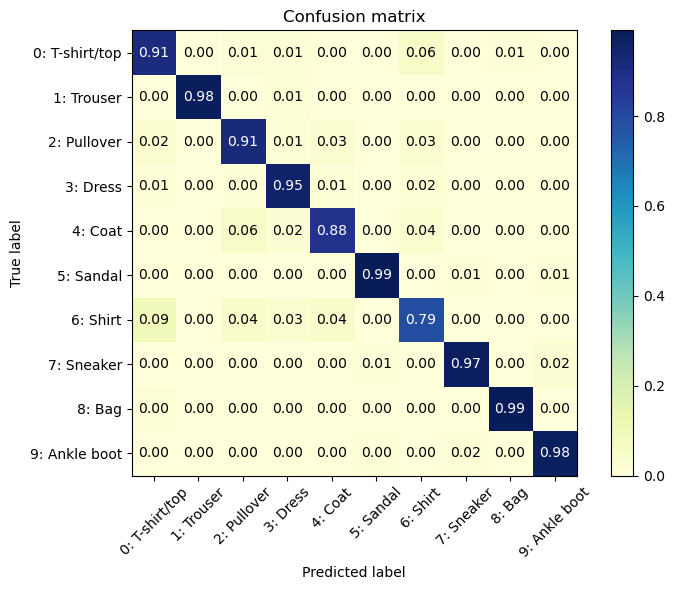

In [20]:
# Make predictions on the test set
y_pred = artifact_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plot_confusion_matrix(cm, classes=class_names, normalize=True)

### Classification report

In [21]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes, average=None)

print(f"{'':<12} | {'Precision':<10} | {'Recall':<10} | {'F1-score':<10} | {'Support':<10}")
for i, label in enumerate(class_names):
    print(f"{label:<12} | {precision[i]:<10.2f} | {recall[i]:<10.2f} | {f1[i]:<10.2f} | {support[i]:<10.2f}")


             | Precision  | Recall     | F1-score   | Support   
T-shirt/top  | 0.87       | 0.91       | 0.89       | 1000.00   
Trouser      | 1.00       | 0.98       | 0.99       | 1000.00   
Pullover     | 0.88       | 0.91       | 0.90       | 1000.00   
Dress        | 0.92       | 0.95       | 0.94       | 1000.00   
Coat         | 0.91       | 0.88       | 0.90       | 1000.00   
Sandal       | 0.99       | 0.99       | 0.99       | 1000.00   
Shirt        | 0.85       | 0.79       | 0.82       | 1000.00   
Sneaker      | 0.97       | 0.97       | 0.97       | 1000.00   
Bag          | 0.99       | 0.99       | 0.99       | 1000.00   
Ankle boot   | 0.97       | 0.98       | 0.98       | 1000.00   


## Analyze incorrect classifications

As seen from the confusion matrix, the errors happen most often on specific categories. We will explore these classses to get a better understanding of the behaviour of our model.

The `plot_misclassified_images` plots 4 pictures of incorrect classification and 4 pictures of clothes corresponding to the predicted label. This will help us get a better understanding of the errors.

In [22]:
def plot_misclassified_images(images: np.ndarray,
                              true_labels: np.ndarray,
                              predicted_labels: np.ndarray,
                              class_names: List[str],
                              n: int = 8,
                              true_class: int = None,
                              pred_class: int = None) -> None:
    """
    Plots a grid of misclassified images along with their true and predicted labels.

    Args:
        images (np.ndarray): An array of shape (num_images, height, width) containing the image data.
        true_labels (np.ndarray): An array of shape (num_images,) containing the true class labels.
        predicted_labels (np.ndarray): An array of shape (num_images,) containing the predicted class labels.
        class_names (List[str]): A list of strings containing the names of the classes.
        n (int): The number of misclassified images to plot (default is 4).
        true_class (int): If not None, only plot misclassified images where the true class is equal to true_class.
        pred_class (int): If not None, only plot misclassified images where the predicted class is equal to pred_class.
    """
    
    # Get the misclassified images and their true/predicted labels
    misclassified_idx = np.where(true_labels != predicted_labels)[0]
    
    
    if true_class is not None:
        misclassified_idx = np.intersect1d(misclassified_idx, np.where(true_labels == true_class)[0])
    if pred_class is not None:
        misclassified_idx = np.intersect1d(misclassified_idx, np.where(predicted_labels == pred_class)[0])
        
    misclassified_images = images[misclassified_idx[:n]]
    misclassified_true_labels = true_labels[misclassified_idx[:n]]
    misclassified_predicted_labels = predicted_labels[misclassified_idx[:n]]

    # Plot the misclassified images with their true/predicted labels
    fig, axes = plt.subplots(2, 4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        _index = np.random.randint(len(misclassified_true_labels))
        if i < 4:
            ax.imshow(misclassified_images[_index], cmap='binary')
            ax.set_title(f"True: {class_names[misclassified_true_labels[_index]]}\nPredicted: {class_names[misclassified_predicted_labels[_index]]}")
        else:
            ax.imshow(images[y_test == pred_class][_index], cmap='binary')
            ax.set_title(f"Label: {class_names[pred_class]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

### Predicted: Shirt 

As seen from the confusion matrix, the Shirt category has the lowest recall, getting confused with the category T-Shirt/top, as well as the Pullover/Dress and coat.
Looking at the plot below, we can see that this is expected, as many items of the top row (incorrect classifications) are similar to those of the second (pedicted label prictures).

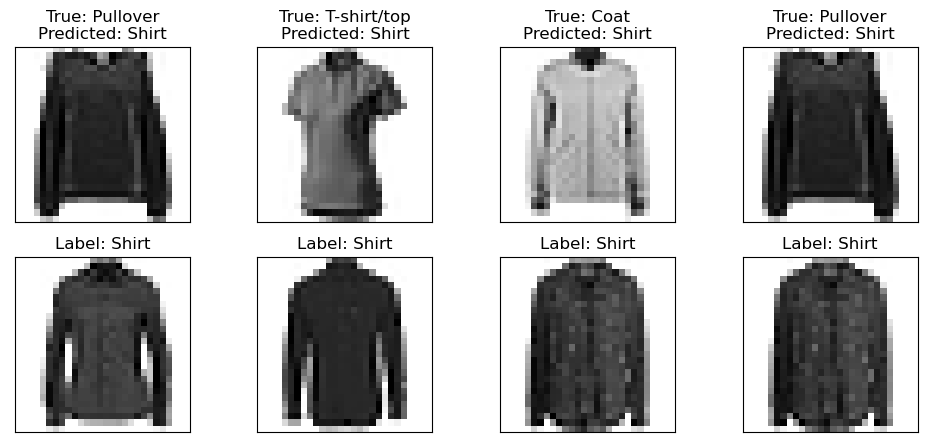

In [23]:
plot_misclassified_images(X_test, y_true_classes, y_pred_classes, class_names, pred_class=6)

### Predicted: T-shirt/top 
Similarly, the T-shirt/top category is often confused with the Shirt one (which makes sense looking ath the image below). 

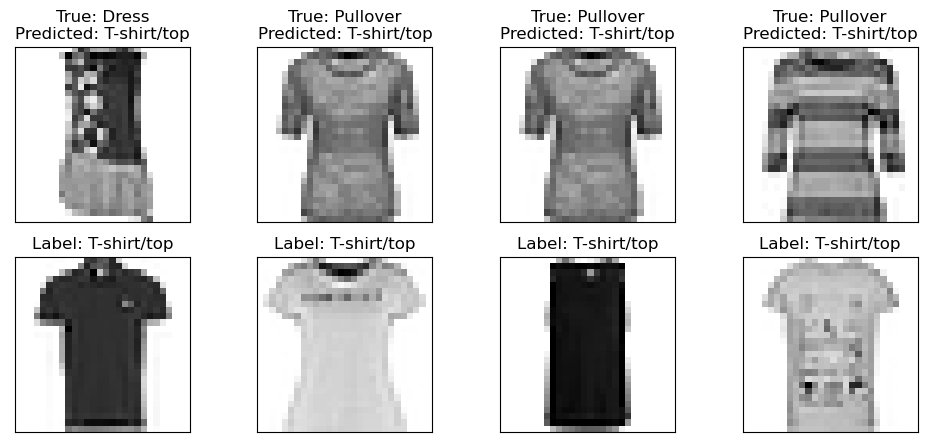

In [26]:
plot_misclassified_images(X_test, y_true_classes, y_pred_classes, class_names, pred_class=0)

### Predicted: Pullover

Pullovers are confused with Coats and Shirts, which can be expected, as seen from the image below.

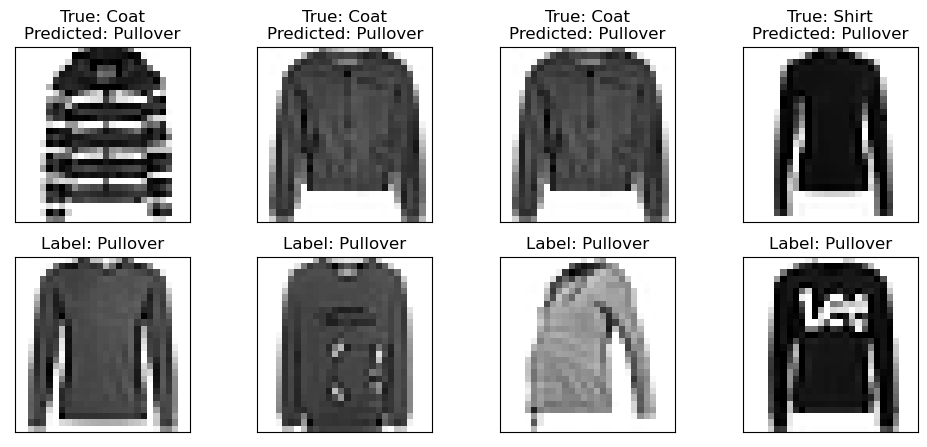

In [27]:
plot_misclassified_images(X_test, y_true_classes, y_pred_classes, class_names, pred_class=2)

### Predicted: Coat

Coats are confused with Pullovers and Shirts, which can be expected, as seen from the image below.

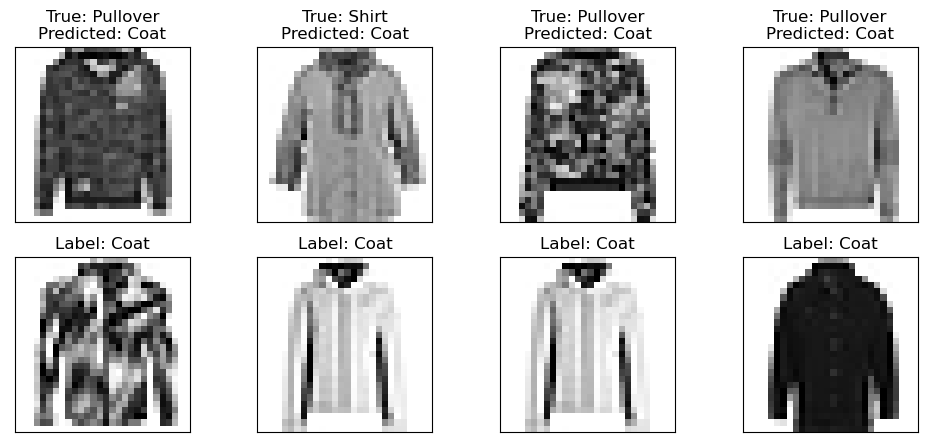

In [28]:
plot_misclassified_images(X_test, y_true_classes, y_pred_classes, class_names, pred_class=4)

# Appendix

Use all training data to make predictions. The `train_model` function has to be changed not to use validation data in training.

In [ ]:
optimizer, early_stopping, reduceLR = opt_es(learning_rate=0.0001)

model, hs = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=25,
    batch_size=64,
    filter_size=[512, 512, 128, 64],
    kernel_size=[5, 3, 7, 5],
    batch_norm=[False, False, True, False],
    max_pooling_size=[4, 0, 2, 0],
    dropout=[0, 0, 0, 0.6],
    conv_activation='relu',
    output_activation='softmax',
    callbacks=[early_stopping, reduceLR], 
    verbose=1

)

# Evaluate on test data and show all the results.
_eval = model.evaluate(X_test, Y_test, verbose=1)
print_eval(hs, _eval)